In [58]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [59]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.4.0
2.4.3


In [60]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14391483196688658930
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8472426176
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6697254219462468851
physical_device_desc: "device: 0, name: GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [61]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 400)

### Loading data

In [62]:
stock_list = ['Alior Bank', 'Allegro', 'Asseco', 'CCC', 'CD Projekt', 'Cyfrowy Polsat', 'Dino Polska', 'JSW', 'KGHM', 'Lotos', 'LPP', 'Orange Polska', 'PEKAO', 'PGE', 'PGNiG', 'PKN Orlen', 'PKO BP', 'PZU', 'Santander', 'Tauron']

directory = "WiG20 data/"
stock_data_list = []
stock_data = pd.DataFrame(columns=['Date', 'Open', 'Highest', 'Lowest', 'Close', 'Volume'])

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    single_stock_data = pd.read_csv(file_path)
    single_stock_data = single_stock_data.rename(columns={'Data': 'Date', 'Otwarcie': 'Open', 'Najwyzszy': 'Highest', 'Najnizszy': 'Lowest', 'Zamkniecie': 'Close', 'Wolumen': 'Volume'})
    single_stock_data['Date'] = pd.to_datetime(single_stock_data.Date)
    stock_data_list.append(single_stock_data)
    single_stock_data['Stock'] = (filename[:3]).upper()
    stock_data = stock_data.append(single_stock_data, ignore_index=True)
    print('Loaded file: ' + filename)

Loaded file: acp_d.csv
Loaded file: ale_d.csv
Loaded file: alr_d.csv
Loaded file: ccc_d.csv
Loaded file: cdr_d.csv
Loaded file: cps_d.csv
Loaded file: dnp_d.csv
Loaded file: jsw_d.csv
Loaded file: kgh_d.csv
Loaded file: lpp_d.csv
Loaded file: lts_d.csv
Loaded file: opl_d.csv
Loaded file: peo_d.csv
Loaded file: pge_d.csv
Loaded file: pgn_d.csv
Loaded file: pkn_d.csv
Loaded file: pko_d.csv
Loaded file: pzu_d.csv
Loaded file: san_d.csv
Loaded file: tpe_d.csv


In [63]:
for i in range(len(stock_data_list)):
    stock_data_list[i] = stock_data_list[i].dropna()

In [64]:
def scale_data(data):
    list_of_features = []
    list_of_outputs = []
    for column in data.columns:
        list_of_features.append(data[column])
        if column in ['Open', 'Close', 'Highest', 'Lowest', 'Volume', 'Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie', 'Wolumen']:
            list_of_outputs.append(data[column])
        
    dataset = np.transpose(list_of_features)
    output_dataset = np.transpose(list_of_outputs)
    X_scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = X_scaler.fit_transform(dataset)
    Y_scaler = MinMaxScaler(feature_range=(0,1))
    Y_scaler.fit_transform(output_dataset)

    return scaled_data, X_scaler, Y_scaler

In [65]:
def prepare_input_and_output(data, number_of_sessions=60):
    # number_of_sessions - number of considered previous sessions as an input
    X = []
    Y = []
    for i in range(number_of_sessions, data.shape[0]):
        X.append(data[i-number_of_sessions:i, :])
        Y.append(data[i, :5])
    return X, Y

In [66]:
# Evaluation of the results is made on closing prices - it gives the most information about the usefullness of the model

def evaluate_results(X_valid, Y_valid, Y_scalers, predictions):

    predictions = Y_scalers[-1].inverse_transform(predictions)
    real_output = Y_scalers[-1].inverse_transform(Y_valid)

    predicted_data = pd.DataFrame(predictions, columns=['Open_predicted', 'Highest_predicted', 'Lowest_predicted', 'Close_predicted', 'Volume_predicted'])
    real_data = pd.DataFrame(real_output, columns=['Open_real', 'Highest_real', 'Lowest_real', 'Close_real', 'Volume_real'])
    predictions = pd.concat([real_data, predicted_data], axis=1)
    print(predictions[['Close_real', 'Close_predicted']].tail(20))

    predictions['Close_difference'] = abs(predictions['Close_real'] - predictions['Close_predicted'])
    predictions['Close_difference_percent'] = abs(predictions['Close_real'] - predictions['Close_predicted'])/predictions['Close_real'] * 100

    previous_close = predictions['Close_real'].shift(-1)
    Naive_forcast_MAPE = (abs(predictions['Close_real'] - previous_close)/predictions['Close_real'] * 100).mean()
    predictions_MAPE = predictions['Close_difference_percent'].mean()

    print('Naive forcast MAE: ' + str(round(abs(previous_close - predictions['Close_real']).mean(),2)))
    print('Predictions MAE: ' + str(round(predictions['Close_difference'].mean(),2)))
    print('Naive forcast MAPE: ' + str(round(Naive_forcast_MAPE,2)) + '%')
    print('Predictions MAPE: ' + str(round(predictions_MAPE,2)) + '%')
    
    return predictions

In [67]:
scaled_stocks = []
X_scalers = []
Y_scalers = []

for i in range(len(stock_data_list)):
    # Date is dropped as it isn't considered for learning
    scaled_stock, X_scaler, Y_scaler = scale_data(stock_data_list[i].drop(columns=['Stock', 'Date']))
  
    scaled_stocks.append(scaled_stock)
    X_scalers.append(X_scaler)
    Y_scalers.append(Y_scaler)

In [68]:
X_all = []
Y_all = []
scaled_X_list = []
scaled_Y_list = []

for stock in scaled_stocks:
    X, Y = prepare_input_and_output(stock, 60)
    scaled_X_list.append(np.array(X))
    scaled_Y_list.append(np.array(Y))
    X_all = X_all + X
    Y_all = Y_all + Y

X_all, Y_all = np.array(X_all), np.array(Y_all)
print('Shape of input matrix: ' + str(X_all.shape))
print('Shape of output matrix: ' + str(Y_all.shape))

Shape of input matrix: (76328, 60, 5)
Shape of output matrix: (76328, 5)


In [69]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=2666 - 60, shuffle=False)

### Defining and evaluating the model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_6 (Dense)              (None, 300)               38700     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1505      
Total params: 108,813
Trainable params: 108,813
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2304/2304 [==============================] - 15s 6ms/step - loss: 0.0026 - val_loss: 3.5557e-04
Epoch 2/15
2304/2304 [==============================] - 13s 6ms/step - loss: 4.9402e-04 - val_loss: 3.5960e-04
Epoch 3/15
2304/2304 [==============================] - 13s 6ms/step - loss: 4.7591e-04 - val_loss: 3.1315e-04
Epoch 4/15
2304/2304 [===========================

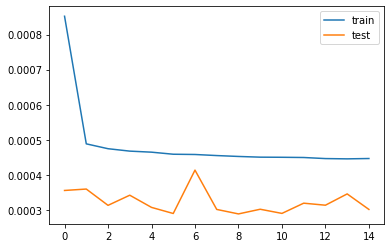

In [70]:
model = Sequential()
model.add(LSTM(128, input_shape=[X_train.shape[1], X_train.shape[2]]))#, return_sequences=True))
# model.add(LSTM(32))
model.add(Dense(300, activation='relu'))
model.add(Dense(Y_train.shape[1]))

model.summary()

model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=15, validation_data=(X_valid, Y_valid))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [71]:
predictions_basic = model.predict(X_valid)

predictions = evaluate_results(X_valid, Y_valid, Y_scalers, predictions_basic) # returns dataset

      Close_real  Close_predicted
2586       2.850         2.820040
2587       2.818         2.835832
2588       2.868         2.803380
2589       2.894         2.849127
2590       2.790         2.879271
2591       2.802         2.780250
2592       2.826         2.792937
2593       2.770         2.814128
2594       2.780         2.758836
2595       2.774         2.768404
2596       2.770         2.761751
2597       2.722         2.755238
2598       2.700         2.711609
2599       2.634         2.687972
2600       2.524         2.624471
2601       2.524         2.520712
2602       2.500         2.525274
2603       2.560         2.496926
2604       2.562         2.552405
2605       2.554         2.546905
Naive forcast MAE: 0.05
Predictions MAE: 0.05
Naive forcast MAPE: 1.59%
Predictions MAPE: 1.66%


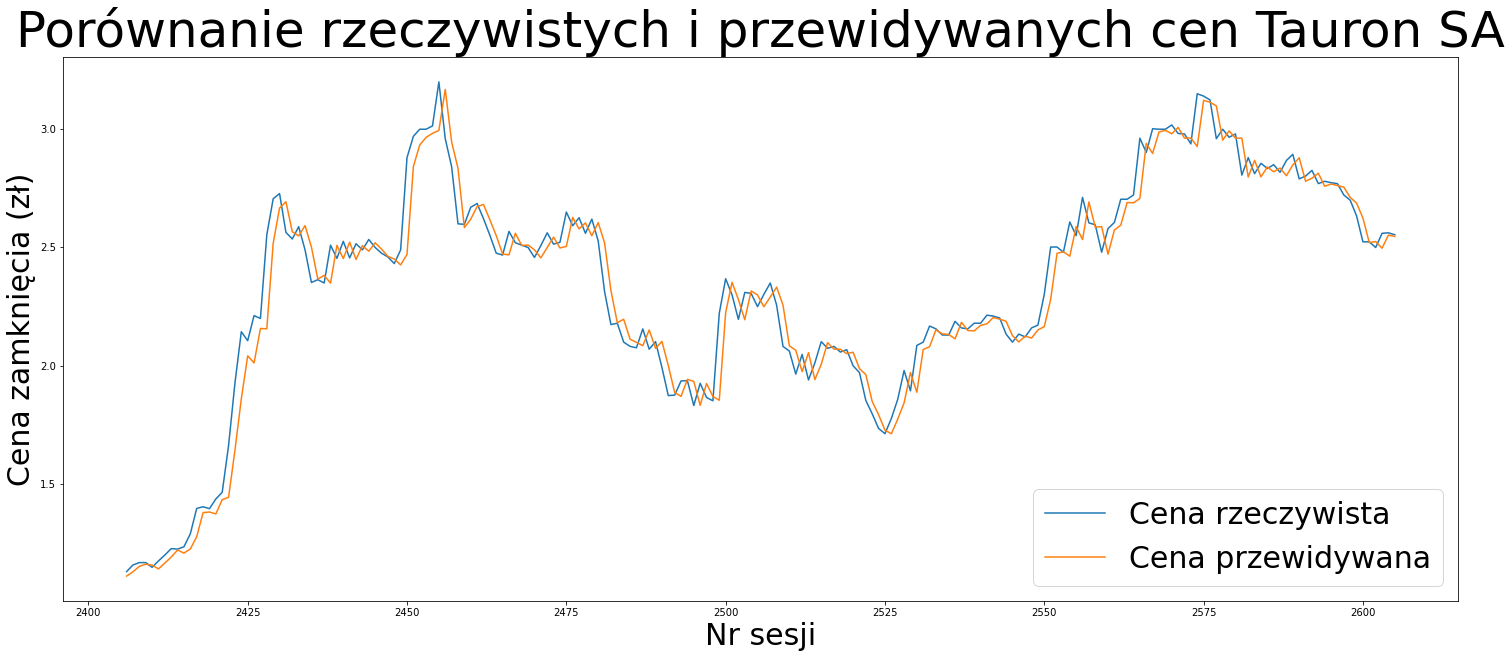

In [72]:
plt.figure(figsize=(25,10))
plt.title('Porównanie rzeczywistych i przewidywanych cen Tauron SA', fontsize=50)
plt.xlabel('Nr sesji', fontsize=30)
plt.ylabel('Cena zamknięcia (zł)', fontsize=30)
plt.plot(predictions['Close_real'].iloc[-200:])
plt.plot(predictions['Close_predicted'].iloc[-200:])
plt.legend(['Cena rzeczywista',  'Cena przewidywana'], loc='lower right', fontsize=30)
plt.show()

### Predictions on multiple days

In [73]:
stock_data

,Date,Open,Highest,Lowest,Close,Volume,Stock
0,1998-06-02,11.071,11.071,11.071,11.071,553241,ACP
1,1998-06-03,12.163,12.163,12.163,12.163,212085,ACP
2,1998-06-04,13.255,13.255,13.255,13.255,628114,ACP
3,1998-06-05,13.415,13.415,13.415,13.415,241411,ACP
4,1998-06-08,13.360,13.360,13.360,13.360,135799,ACP
...,...,...,...,...,...,...,...
77524,2021-02-24,2.500,2.600,2.482,2.524,5424053,TPE
77525,2021-02-25,2.560,2.600,2.472,2.500,6324046,TPE
77526,2021-02-26,2.470,2.598,2.450,2.560,8567511,TPE
77527,2021-03-01,2.620,2.630,2.524,2.562,4569881,TPE


In [122]:
# passed values are input_vector sized (60, 5) (60 days * 5 features - Open, Highest, Lowest, Close, Volume) and n number of days we want to predict 
# returns vector (n, 5) with predictions
def predict_n_days_NN(input_vector, n):
    scaler = MinMaxScaler(feature_range=(0,1))
    X = scaler.fit_transform(input_vector)
    X = np.array(X).reshape(1, 60, 5)
    X_predicted = X
    predictions = []
    
    for day in range(n):
        prediction = model.predict(X_predicted)
        X_predicted = np.roll(X_predicted, -1, axis=1)
        X_predicted[:, -1, :] = prediction
        predictions.append(prediction)
    
#     X_predicted = scaler.inverse_transform(X_predicted.reshape(60, 5))
    predictions = np.array(predictions)
    predictions = scaler.inverse_transform(predictions.reshape(n, 5))
    
    return (predictions)

In [75]:
def predict_n_days_LR(input_vector, n):
    X = np.arange(0, input_vector.shape[0]).reshape(-1,1)
    lin_regr = LinearRegression().fit(X, input_vector)
    X_pred = np.arange(input_vector.shape[0] + 1, input_vector.shape[0] + n + 1).reshape(-1,1)
    prediction = lin_regr.predict(X_pred)
    return prediction
    

In [76]:
predictions_30_NN = predict_n_days_NN(stock_data.loc[stock_data['Stock'] == 'TPE', ['Open', 'Highest', 'Lowest', 'Close', 'Volume']][1000:1060], 30)

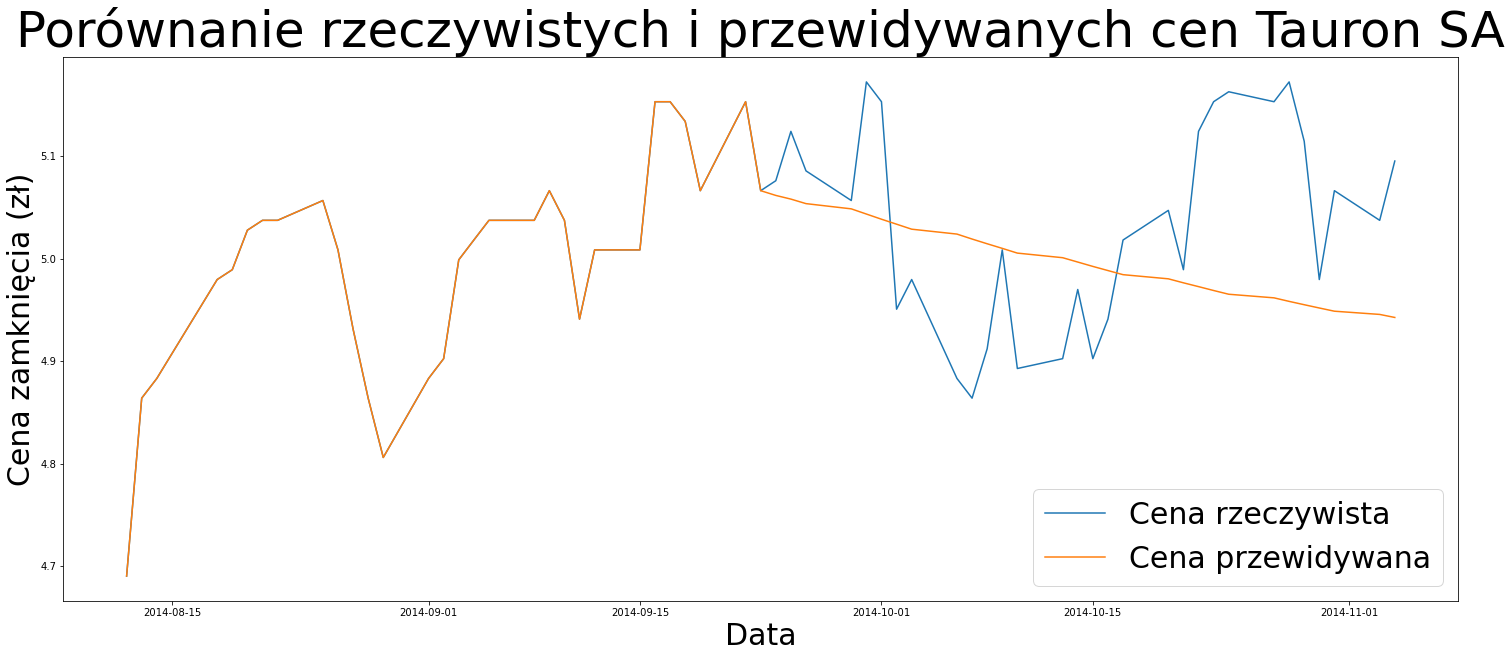

In [77]:
plt.figure(figsize=(25,10))
plt.title('Porównanie rzeczywistych i przewidywanych cen Tauron SA', fontsize=50)
plt.xlabel('Data', fontsize=30)
plt.ylabel('Cena zamknięcia (zł)', fontsize=30)
plt.plot(stock_data.loc[stock_data['Stock'] == 'TPE', 'Date'][1030:1090].values, stock_data.loc[stock_data['Stock'] == 'TPE', 'Close'][1030:1090].values)
plt.plot(stock_data.loc[stock_data['Stock'] == 'TPE', 'Date'][1030:1090].values, np.concatenate((stock_data.loc[stock_data['Stock'] == 'TPE', 'Close'][1030:1060].values, predictions_30_NN[:, 3])))
plt.legend(['Cena rzeczywista',  'Cena przewidywana'], loc='lower right', fontsize=30)
plt.show()

In [78]:
predictions_30_LR = predict_n_days_LR(stock_data.loc[stock_data['Stock'] == 'TPE', ['Open', 'Highest', 'Lowest', 'Close', 'Volume']][1000:1060], 30)

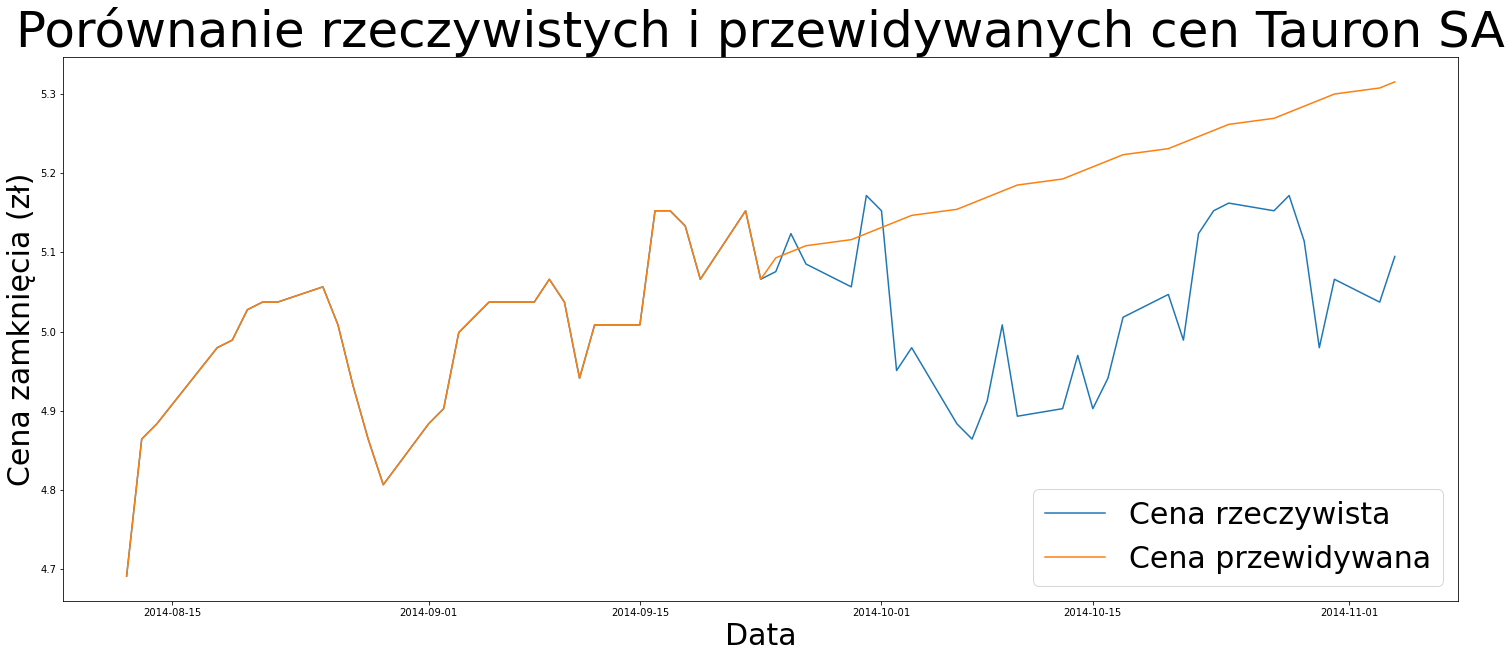

In [79]:
plt.figure(figsize=(25,10))
plt.title('Porównanie rzeczywistych i przewidywanych cen Tauron SA', fontsize=50)
plt.xlabel('Data', fontsize=30)
plt.ylabel('Cena zamknięcia (zł)', fontsize=30)
plt.plot(stock_data.loc[stock_data['Stock'] == 'TPE', 'Date'][1030:1090].values, stock_data.loc[stock_data['Stock'] == 'TPE', 'Close'][1030:1090].values)
plt.plot(stock_data.loc[stock_data['Stock'] == 'TPE', 'Date'][1030:1090].values, np.concatenate((stock_data.loc[stock_data['Stock'] == 'TPE', 'Close'][1030:1060].values, predictions_30_LR[:, 3])))
plt.legend(['Cena rzeczywista',  'Cena przewidywana'], loc='lower right', fontsize=30)
plt.show()

The curvature of the linear regression predictions is caused by the plot being based on dates. On weekends and some other days the stock sessions are closed. <br>
When the plot's X-axis is a evenly distributed date, the session based linear plot gets disturbed. Prove below.

In [80]:
plot_LR = pd.DataFrame(predictions_30_LR, columns=['Open', 'Highest', 'Lowest', 'Close', 'Volume'])

<AxesSubplot:>

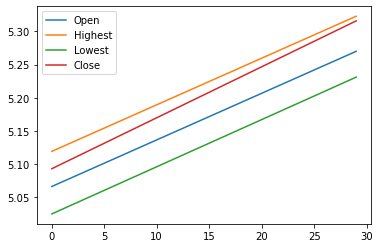

In [81]:
plot_LR[['Open', 'Highest', 'Lowest', 'Close']].plot() # the volume is droped as it's value is much greater than the prices.

Plot of the Neural Network predictions for comparision

In [82]:
plot_NN = pd.DataFrame(predictions_30_NN, columns=['Open', 'Highest', 'Lowest', 'Close', 'Volume'])

<AxesSubplot:>

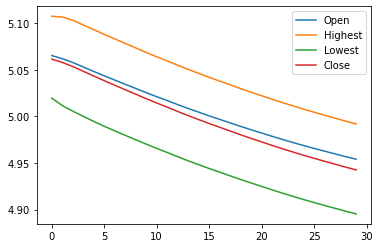

In [83]:
plot_NN[['Open', 'Highest', 'Lowest', 'Close']].plot() # the volume is droped as it's value is much greater than the prices.

## Evaluation of the predictions

In [124]:
stock = 'TPE'
stock_len = len(stock_data.loc[stock_data['Stock'] == stock])
start_idx = 60
days_to_predict = 1
end_idx = stock_len

predictions = pd.DataFrame(columns=['Date','Open_real','Highest_real','Lowest_real','Close_real','Volume_real','Prediction_days', 
                                    'Open_NN','Highest_NN','Lowest_NN','Close_NN','Volume_NN',
                                    'Open_LR','Highest_LR','Lowest_LR','Close_LR','Volume_LR'
                                   ])

for idx in range(start_idx, end_idx):
    if idx % 100 == 0:
        print(idx)
    predictions_NN = predict_n_days_NN(stock_data.loc[stock_data['Stock'] == stock, ['Open', 'Highest', 'Lowest', 'Close', 'Volume']][idx-60:idx], days_to_predict)
    predictions_LR = predict_n_days_LR(stock_data.loc[stock_data['Stock'] == stock, ['Open', 'Highest', 'Lowest', 'Close', 'Volume']][idx-60:idx], days_to_predict)
    
    for day in range(1, days_to_predict + 1):
        if idx + day == stock_len-1:
            break
        date = stock_data.loc[stock_data['Stock'] == stock, ['Date']].iloc[idx + day-1].tolist()
        real_values = stock_data.loc[stock_data['Stock'] == stock, ['Open', 'Highest', 'Lowest', 'Close', 'Volume']].iloc[idx + day-1].tolist()
        
        row = date + real_values + [day] + predictions_NN[day-1].tolist() + predictions_LR[day-1].tolist()
        row = pd.Series(row, index=predictions.columns)
        predictions = predictions.append(row, ignore_index=True)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [126]:
predictions.head()

,Date,Open_real,Highest_real,Lowest_real,Close_real,Volume_real,Prediction_days,Open_NN,Highest_NN,Lowest_NN,Close_NN,Volume_NN,Open_LR,Highest_LR,Lowest_LR,Close_LR,Volume_LR
0,2010-09-22,4.8825,4.8907,4.7693,4.8178,10344322,1,4.902177,4.919191,4.850383,4.885038,8044737.5,4.616951,4.685378,4.591939,4.655892,7.366161e+05
1,2010-09-23,4.8017,4.8017,4.6966,4.7127,5512414,1,4.830640,4.853742,4.775750,4.819001,9006901.0,4.655268,4.720563,4.620989,4.685533,4.459954e+06
2,2010-09-24,4.6884,4.9148,4.6884,4.9148,6156058,1,4.733323,4.757903,4.684505,4.720126,7962550.5,4.683091,4.746181,4.642284,4.706640,4.843746e+06
3,2010-09-27,4.9309,4.9471,4.8907,4.9066,5389625,1,4.916398,4.947757,4.846972,4.902477,7862692.0,4.703342,4.778884,4.664490,4.740742,4.668238e+06
4,2010-09-28,4.8987,4.9390,4.8178,4.9229,4281233,1,4.912564,4.929073,4.857445,4.896602,6237531.5,4.739110,4.812098,4.699453,4.772546,4.400379e+06


In [127]:
for column in predictions.columns:
    if column in ['Date', 'Prediction_days', 'Volume_real']:
        continue
    if column in ['Volume_NN', 'Volume_LR']:
        predictions[column] = predictions[column].astype('int32')
        continue
    predictions[column] = predictions[column].round(2)

predictions.head(20)

,Date,Open_real,Highest_real,Lowest_real,Close_real,Volume_real,Prediction_days,Open_NN,Highest_NN,Lowest_NN,Close_NN,Volume_NN,Open_LR,Highest_LR,Lowest_LR,Close_LR,Volume_LR
0,2010-09-22,4.88,4.89,4.77,4.82,10344322,1,4.90,4.92,4.85,4.89,8044737,4.62,4.69,4.59,4.66,736616
1,2010-09-23,4.80,4.80,4.70,4.71,5512414,1,4.83,4.85,4.78,4.82,9006901,4.66,4.72,4.62,4.69,4459953
2,2010-09-24,4.69,4.91,4.69,4.91,6156058,1,4.73,4.76,4.68,4.72,7962550,4.68,4.75,4.64,4.71,4843745
3,2010-09-27,4.93,4.95,4.89,4.91,5389625,1,4.92,4.95,4.85,4.90,7862692,4.70,4.78,4.66,4.74,4668238
4,2010-09-28,4.90,4.94,4.82,4.92,4281233,1,4.91,4.93,4.86,4.90,6237531,4.74,4.81,4.70,4.77,4400378
5,2010-09-29,4.92,4.96,4.86,4.92,2044680,1,4.92,4.94,4.86,4.90,6699925,4.77,4.84,4.73,4.80,4039569
6,2010-09-30,4.89,4.94,4.87,4.94,4487451,1,4.93,4.94,4.87,4.91,5463139,4.80,4.87,4.76,4.83,3587433
7,2010-10-01,4.93,4.94,4.90,4.93,2947977,1,4.94,4.95,4.89,4.93,5373602,4.83,4.90,4.79,4.87,3458204
8,2010-10-04,4.93,4.97,4.89,4.97,3938708,1,4.93,4.94,4.88,4.92,5013109,4.86,4.93,4.82,4.90,3240787
9,2010-10-05,4.96,5.00,4.93,5.00,3082990,1,4.97,4.98,4.92,4.95,5353671,4.89,4.96,4.85,4.93,3783226


In [128]:
predictions_evaluation = pd.DataFrame(columns = ['Prediction_days', 'NN_open_MAPE', 'NN_highest_MAPE', 'NN_lowest_MAPE', 'NN_close_MAPE', 'NN_volume_MAPE',
                                                 'LR_open_MAPE', 'LR_highest_MAPE', 'LR_lowest_MAPE', 'LR_close_MAPE', 'LR_volume_MAPE',
                                                 'Naive_open_MAPE', 'Naive_highest_MAPE', 'Naive_lowest_MAPE', 'Naive_close_MAPE', 'Naive_volume_MAPE'])

for day in range(1, days_to_predict + 1):
    NN_open_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Open_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Open_NN'])/predictions.loc[predictions['Prediction_days'] == day, 'Open_real']).abs().mean() * 100
    NN_highest_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Highest_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Highest_NN'])/predictions.loc[predictions['Prediction_days'] == day, 'Highest_real']).abs().mean() * 100
    NN_lowest_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Lowest_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Lowest_NN'])/predictions.loc[predictions['Prediction_days'] == day, 'Lowest_real']).abs().mean() * 100
    NN_close_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Close_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Close_NN'])/predictions.loc[predictions['Prediction_days'] == day, 'Close_real']).abs().mean() * 100
    NN_volume_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Volume_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Volume_NN'])/predictions.loc[predictions['Prediction_days'] == day, 'Volume_real']).abs().mean() * 100
    
    LR_open_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Open_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Open_LR'])/predictions.loc[predictions['Prediction_days'] == day, 'Open_real']).abs().mean() * 100
    LR_highest_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Highest_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Highest_LR'])/predictions.loc[predictions['Prediction_days'] == day, 'Highest_real']).abs().mean() * 100
    LR_lowest_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Lowest_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Lowest_LR'])/predictions.loc[predictions['Prediction_days'] == day, 'Lowest_real']).abs().mean() * 100
    LR_close_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Close_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Close_LR'])/predictions.loc[predictions['Prediction_days'] == day, 'Close_real']).abs().mean() * 100
    LR_volume_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Volume_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Volume_LR'])/predictions.loc[predictions['Prediction_days'] == day, 'Volume_real']).abs().mean() * 100    
    
    Naive_open_MAPE = (abs(predictions.loc[predictions['Prediction_days'] == day, 'Open_real'].diff(periods=day)) / predictions.loc[predictions['Prediction_days'] == day, 'Open_real']).mean() * 100
    Naive_highest_MAPE = (abs(predictions.loc[predictions['Prediction_days'] == day, 'Highest_real'].diff(periods=day)) / predictions.loc[predictions['Prediction_days'] == day, 'Highest_real']).mean() * 100
    Naive_lowest_MAPE = (abs(predictions.loc[predictions['Prediction_days'] == day, 'Lowest_real'].diff(periods=day)) / predictions.loc[predictions['Prediction_days'] == day, 'Lowest_real']).mean() * 100
    Naive_close_MAPE = (abs(predictions.loc[predictions['Prediction_days'] == day, 'Close_real'].diff(periods=day)) / predictions.loc[predictions['Prediction_days'] == day, 'Close_real']).mean() * 100
    Naive_volume_MAPE = (abs(predictions.loc[predictions['Prediction_days'] == day, 'Volume_real'].diff(periods=day)) / predictions.loc[predictions['Prediction_days'] == day, 'Volume_real']).mean() * 100
    
    row = [day, NN_open_MAPE, NN_highest_MAPE, NN_lowest_MAPE, NN_close_MAPE, NN_volume_MAPE, 
           LR_open_MAPE, LR_highest_MAPE, LR_lowest_MAPE, LR_close_MAPE, LR_volume_MAPE, 
           Naive_open_MAPE, Naive_highest_MAPE, Naive_lowest_MAPE, Naive_close_MAPE, Naive_volume_MAPE]
    row = pd.Series(row, index=predictions_evaluation.columns)
    predictions_evaluation = predictions_evaluation.append(row, ignore_index=True)
    
predictions_evaluation['Prediction_days'] = predictions_evaluation['Prediction_days'].astype('int32')

In [129]:
predictions_evaluation

,Prediction_days,NN_open_MAPE,NN_highest_MAPE,NN_lowest_MAPE,NN_close_MAPE,NN_volume_MAPE,LR_open_MAPE,LR_highest_MAPE,LR_lowest_MAPE,LR_close_MAPE,LR_volume_MAPE,Naive_open_MAPE,Naive_highest_MAPE,Naive_lowest_MAPE,Naive_close_MAPE,Naive_volume_MAPE
0,1,0.860853,1.119868,1.202533,1.665721,47.016125,4.871008,4.748485,4.982814,4.957598,60.428343,1.562172,1.302554,1.364893,1.588917,55.288779
